## 1. Importing Dependencies

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualization library
import seaborn as sns # visualization library
import plotly # visualization library
%matplotlib inline
pd.set_option('display.Max_columns', None)
from sklearn.ensemble import ExtraTreesRegressor # For feature selection
from sklearn.feature_selection import chi2, SelectKBest # For feature selection


# Importing base Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


# Importing model tools
from sklearn.model_selection import train_test_split # For splitting the dataset
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Importing metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## 2. Importing Data

In [2]:
df = pd.read_excel(r"C:\Users\49179\Downloads\data\flight fare prediction\Data_Train.xlsx")

## 3. Data Understanding

In [3]:
df.tail(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [4]:
# Checking the shape of data
df.shape

(10683, 11)

In [5]:
#Checking the data types of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
# Checking for missing values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
df[df['Route'].isnull()> 0]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [9]:
# Checking the unique value from each feature
df.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

**Initial insights from the data**

1. As we can see there is only one column which has integer data type. Also, "Dep_time", "Date_of_Journey", "Duration" and "Arrival_time" are temporal variables.

2. Features "Route" and "Total_stops" has one missing value.

3. We can see record 9039 has the missing value in 'Route' and 'Total_stops'.

## 4. Handling Missing Value

In [10]:
# Firstly we'll replace missing value with the Mode from the Route feature
mode = df["Route"].mode()
# Replacing
df['Route'] = np.where(df['Route'].isnull() > 0, mode, df['Route'] )
df['Total_Stops'] = np.where(df['Total_Stops'].isnull() > 0, df['Total_Stops'].mode(), df['Total_Stops'])


In [11]:
[feture for feature in df.columns if df[feature].isnull().sum() > 0]

[]

We have replaced the missing values with the mode. The reason we used mode is that the feature 'Total_stops' and 'Route' both are categorical feature and it makes more sense when you replace it with the more frequently occuring values.

## 5. Feature Generation

Let's first handle temporal variable

In [12]:
# Separating date and month from 
df['date'] = pd.to_datetime(df['Date_of_Journey'],format="%d/%m/%Y").dt.day

df['month'] = pd.to_datetime(df['Date_of_Journey'],format="%d/%m/%Y").dt.month

We are not Creating year feature from it because this dataset contains 2019 data only.

In [13]:
# separating hour and minute from the departure time
df['dep_hour'] = pd.to_datetime(df.Dep_Time).dt.hour

df['dep_mins'] = pd.to_datetime(df.Dep_Time).dt.minute

In [14]:
# separating hour and minute from the departure time
df['Arrival_hour'] = pd.to_datetime(df.Arrival_Time).dt.hour

df['Arrival_mins'] = pd.to_datetime(df.Arrival_Time).dt.minute

For duration we don't need to separate in hour or minutes. We can convert whole feature in minutes as it will be helpful to analyze the how longs the journey was.

In [15]:
# In some of the records duration is not properly recorded. For better interpretation we first set it into simillar format
x = list(df['Duration'])
for i in range(len(x)):
    if len(x[i].split()) != 2:
        if "h" in x[i]:
            x[i] = x[i].strip() + " " + '0m'
        else:
            x[i] = "0h" + " " + x[i]

x_hour_in_mins=[]
x_min=[]
for i in range(len(x)):
    #Extracting hour and converting it into minutes
    x_hour_in_mins.append(int(x[i].split(sep = "h")[0])*60)
    # Extracting minutes from duration
    x_min.append(int(x[i].split(sep = "m")[0].split()[-1]))
    
# making it one feature
df['Duration'] = pd.DataFrame(x_hour_in_mins) + pd.DataFrame(x_min)



In [16]:
df['Duration'].tail()

10678    150
10679    155
10680    180
10681    160
10682    500
Name: Duration, dtype: int64

In [17]:
# Now, let's check the data type of the feature
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration            int64
Total_Stops        object
Additional_Info    object
Price               int64
date                int64
month               int64
dep_hour            int64
dep_mins            int64
Arrival_hour        int64
Arrival_mins        int64
dtype: object

In [18]:
# To increase our models accuracay, we can generate new features according to weekdays and weekends

# Creating a feature named Day_of_Week

df['Day_of_Week'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.dayofweek

# Now, we will create weekend column
df['Weekend'] = (pd.to_datetime(df['Date_of_Journey'],format ='%d/%m/%Y').dt.dayofweek >= 5).astype(int) # This will help to analyze the average flight fare on weekends. 

In [19]:
# Generating a feature based on day time
df['Night'] = (pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.hour >= 19).astype(int) # This will help to analyze the average flight fare during the night time

In [20]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897,24,3,22,20,1,10,6,1,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662,1,5,5,50,13,15,2,0,0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882,9,6,9,25,4,25,6,1,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218,12,5,18,5,23,30,6,1,0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1 stop,No info,13302,1,3,16,50,21,35,4,0,0


## 6. Data Inconsistancy

In [21]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [22]:
stops= {'non-stop': 0,'1 stop': 1, '2 stops' :2, '3 stops' :3, '4 stops': 4}

# let's perform ordinal encoding

df['Total_Stops'] = df['Total_Stops'].map(stops)

In [23]:
df['Total_Stops'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [24]:
df['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

Here, Airlines like Jet Airways Business, Multiple Carriers Premium economy, and Vistara Premium economy is not new category of the Airlines. So, we can change its name.

In [25]:
df['Airline'] =  df['Airline'].replace('Jet Airways Business', 'Jet Airways')
df['Airline'] =  df['Airline'].replace('Vistara Premium economy', 'Vistara')
df['Airline'] =  df['Airline'].replace('Multiple carriers Premium economy', 'Multiple carriers')

In [26]:
df.Airline.nunique()

9

In [27]:
df.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [28]:
df.Destination.unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

It is clear from the source that we have no Airport in New Delhi but in destination it provided. So, it is clearly an error.

In [29]:
df.Destination = df.Destination.replace('New Delhi','Delhi')

In [30]:
df.Destination.unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [31]:
df.Additional_Info.unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [32]:
df.Additional_Info.value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

As we can see the majorityof information is 'No info' so we can drop the feature.

Moreover, We can also drop the "Route" feature as we have source and destination.

## 7. Data Visualizatiion

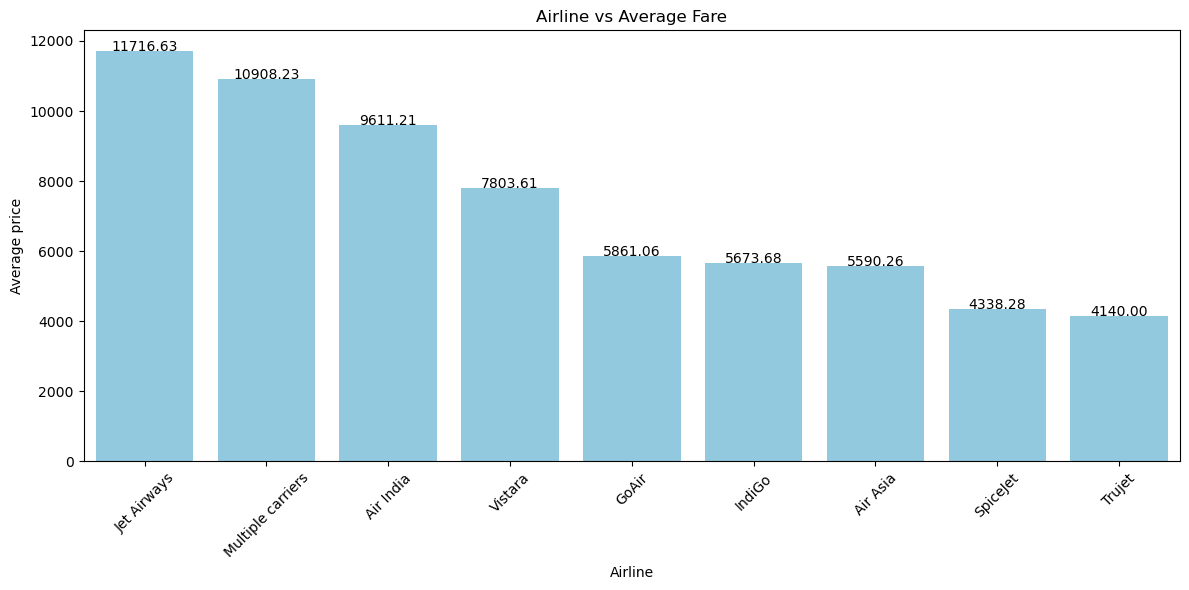

In [33]:
# Visualizing the average fare each airline has.
price_per_airline = df.groupby('Airline')['Price'].mean().reset_index()
price_per_airline= price_per_airline.sort_values(by="Price",ascending =False)
plt.figure(figsize=(12,6))
ax = sns.barplot(data= price_per_airline,x=price_per_airline.Airline, y=price_per_airline.Price, color = 'skyblue')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')

    plt.title('Airline vs Average Fare')
plt.xlabel("Airline")
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar graph above depicts that Jet Airways and Mutiple Crariers has the highest fare than any other airline followed by Air India and Vistara.
Also, SpiceJet and Trujet has the lowest price among ohter airlines.

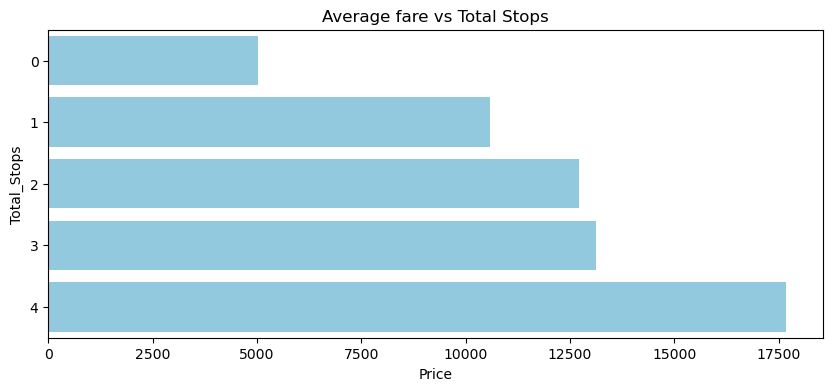

In [34]:
# Visualizing the average fare according to number of stops
import matplotlib
price_by_stops = df.groupby('Total_Stops')['Price'].mean().reset_index()

plt.figure(figsize=(10,4))
ax=sns.barplot(data = price_by_stops, y= price_by_stops.Total_Stops, x = price_by_stops.Price, orient='h', color = 'skyblue')
plt.yticks(df.Total_Stops.unique())
plt.title("Average fare vs Total Stops")
plt.show()

As graph itself elaborates that, The more number of stops the higher the price. We can see that flights with 4-stops has average fare around 17600 rupees while non-stop flights are comparitively a lot cheaper which is almost 5000 rupees.

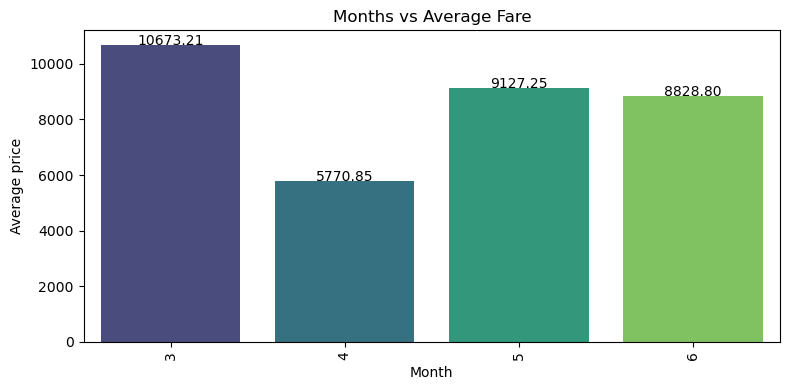

In [35]:
# Visualizing what months has more price

price_by_months = df.groupby('month')["Price"].mean().reset_index()
price_by_months = price_by_months.sort_values(by='Price',ascending=True)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=price_by_months,x=price_by_months.month,y=price_by_months.Price, palette = 'viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')

    plt.title('Months vs Average Fare')
plt.xlabel("Month")
plt.ylabel('Average price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can see that March has the higher fare followed by June and May. April has noted for the low fare of flights

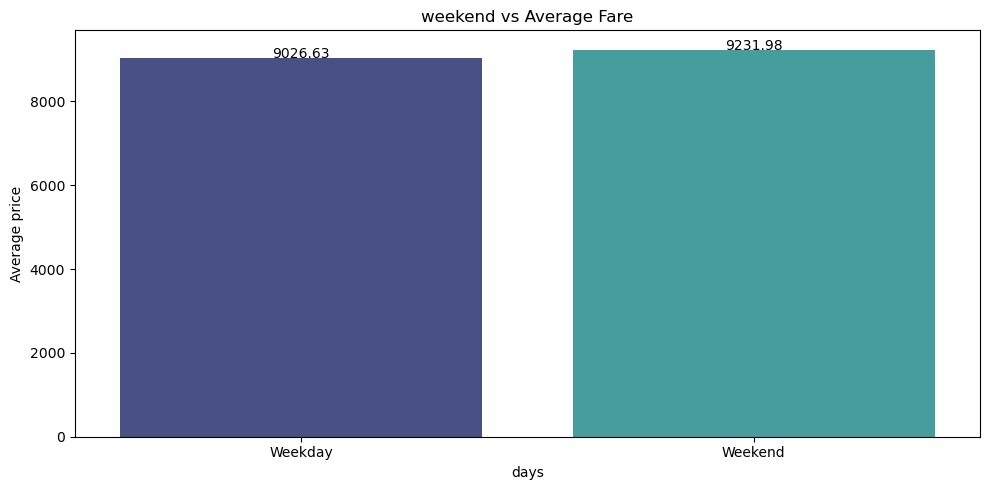

In [36]:
# Visualizing the average fare during the weekends
price_by_days = df.groupby('Weekend')['Price'].mean().reset_index()

plt.figure(figsize=(10,5))
ax = sns.barplot(data=price_by_days,x='Weekend',y='Price', palette = 'mako')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')

    plt.title('weekend vs Average Fare')
plt.xlabel("days")
plt.ylabel('Average price')
plt.xticks([0,1],['Weekday','Weekend'])
plt.tight_layout()
plt.show()


Weekends tend to have price little bit higher than the weekdays.

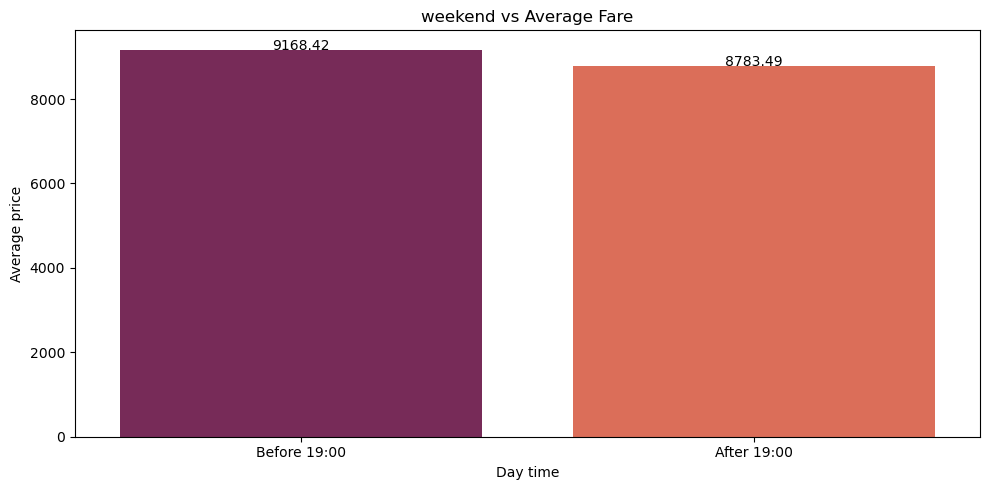

In [37]:
# Visualizing the price according to day time

price_by_time = df.groupby('Night')['Price'].mean().reset_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(data=price_by_time,x='Night',y='Price', palette = 'rocket')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')

    plt.title('weekend vs Average Fare')
plt.xlabel("Day time")
plt.ylabel('Average price')
plt.xticks([0,1],['Before 19:00','After 19:00'])
plt.tight_layout()
plt.show()


<Axes: xlabel='dep_hour', ylabel='count'>

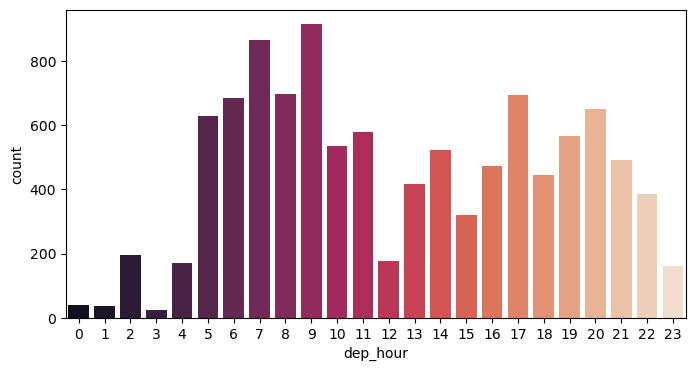

In [38]:
plt.figure(figsize=(8,4))
sns.countplot(data= df,x='dep_hour',palette='rocket')

The above graphs represent that there are more number of flights that departed in the morning between 5 to 11 and the price is also higher than the flights that depart in the evening or night.

<Figure size 1000x400 with 0 Axes>

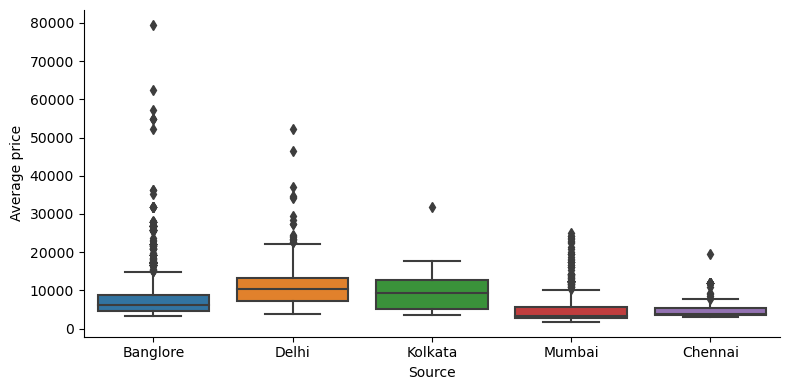

In [39]:
plt.figure(figsize=(10,4))
sns.catplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False),kind='box', height=4, aspect=2)

plt.xlabel("Source")
plt.ylabel('Average price')


plt.show()

Flights that departs from Delhi is colstlier followed by Kolkata. On the other hand, The flights that departs form Chhenai are cheaper.

<Figure size 600x400 with 0 Axes>

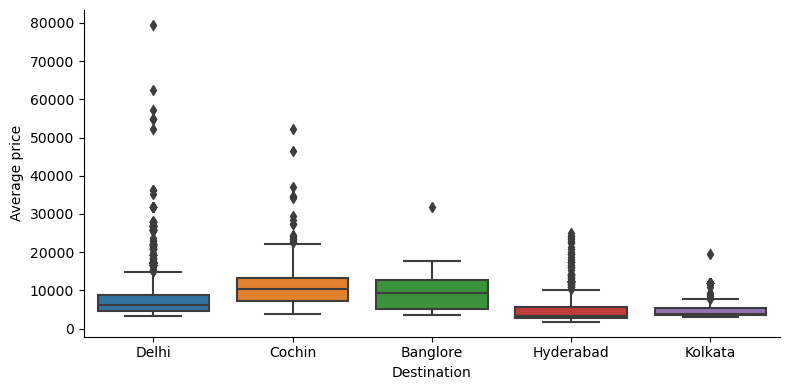

In [40]:
plt.figure(figsize=(6,4))
sns.catplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False),kind='box', height=4, aspect=2)

plt.xlabel("Destination")
plt.ylabel('Average price')


plt.show()

The Box plot above shows that the flights whose destination is Cochin has relatively higher prices than others. Kolkata, on the other hand, has cheapest flights as a destination.

**Let's visualize how our dependent variable 'Price' is distributed.**

C:\Users\49179\AppData\Local\Temp\ipykernel_34208\1063700176.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],ax=ax1)


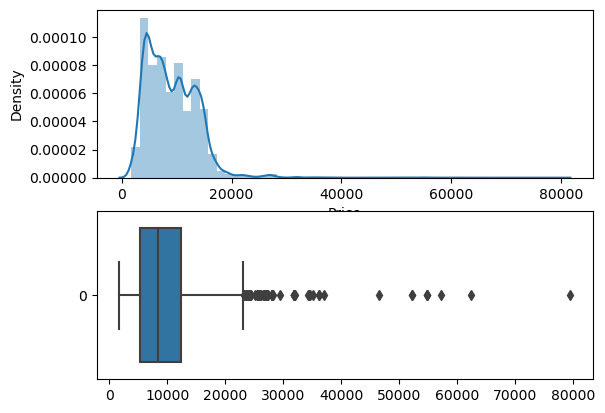

In [41]:
def plot_charts(data, feature):
    fig, (ax1,ax2) = plt.subplots(2,1)
    sns.distplot(data[feature],ax=ax1)
    sns.boxplot(data[feature],ax =ax2,orient='h')
    
plot_charts(df,"Price")


As we can see from the boxplot there are outliers present in the dataset. We can replace those outliers with median value.

In [42]:
# removing outliers 
df['Price'] = np.where(df['Price'] >= 35000, df.Price.median(), df['Price'])

C:\Users\49179\AppData\Local\Temp\ipykernel_34208\1063700176.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],ax=ax1)


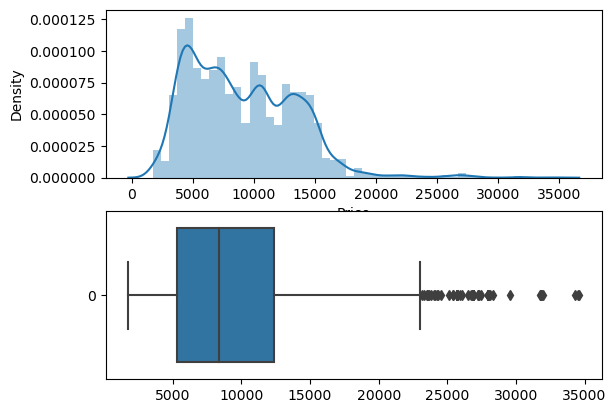

In [43]:
plot_charts(df,"Price")

In [44]:
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,IndiGo,24/03/2019,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,170,0,No info,3897.0,24,3,22,20,1,10,6,1,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2,No info,7662.0,1,5,5,50,13,15,2,0,0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2,No info,13882.0,9,6,9,25,4,25,6,1,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1,No info,6218.0,12,5,18,5,23,30,6,1,0
4,IndiGo,01/03/2019,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,285,1,No info,13302.0,1,3,16,50,21,35,4,0,0


## 8. Encoding the categorical features

In [45]:
# Let's make dummy variables for categorical features
Airline = pd.get_dummies(df['Airline'], prefix ="Airline",prefix_sep="_")
Airline.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Trujet,Airline_Vistara
0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [46]:
src = pd.get_dummies(df['Source'], prefix ="src",prefix_sep="_" ,drop_first=True)
src.head()

,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [47]:
dst = pd.get_dummies(df['Destination'], prefix ="dst",prefix_sep="_" ,drop_first=True)
dst.head()

,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [48]:
#Concating the columns
final_df = pd.concat([Airline,src,dst,df],axis=1)
final_df.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,IndiGo,24/03/2019,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,170,0,No info,3897.0,24,3,22,20,1,10,6,1,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2,No info,7662.0,1,5,5,50,13,15,2,0,0
2,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2,No info,13882.0,9,6,9,25,4,25,6,1,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1,No info,6218.0,12,5,18,5,23,30,6,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,IndiGo,01/03/2019,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,285,1,No info,13302.0,1,3,16,50,21,35,4,0,0


## 9. Dropping the Fetaures

In [49]:
final_df.drop(['Date_of_Journey','Dep_Time','Arrival_Time', 'Route', 'Additional_Info','Airline',"Source", 'Destination'],axis=1, inplace=True)

In [50]:
final_df.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata,Duration,Total_Stops,Price,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,170,0,3897.0,24,3,22,20,1,10,6,1,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,445,2,7662.0,1,5,5,50,13,15,2,0,0
2,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1140,2,13882.0,9,6,9,25,4,25,6,1,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,325,1,6218.0,12,5,18,5,23,30,6,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,285,1,13302.0,1,3,16,50,21,35,4,0,0


In [51]:
final_df.shape

(10683, 29)

Splitting the dataset into dependent and independent variable

In [52]:
X = final_df.drop(['Price',"Airline_Trujet"],axis=1)
y = final_df.Price

In [53]:
X.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Vistara,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata,Duration,Total_Stops,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,170,0,24,3,22,20,1,10,6,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,445,2,1,5,5,50,13,15,2,0,0
2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1140,2,9,6,9,25,4,25,6,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,325,1,12,5,18,5,23,30,6,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,285,1,1,3,16,50,21,35,4,0,0


In [54]:
y.head()

0     3897.0
1     7662.0
2    13882.0
3     6218.0
4    13302.0
Name: Price, dtype: float64

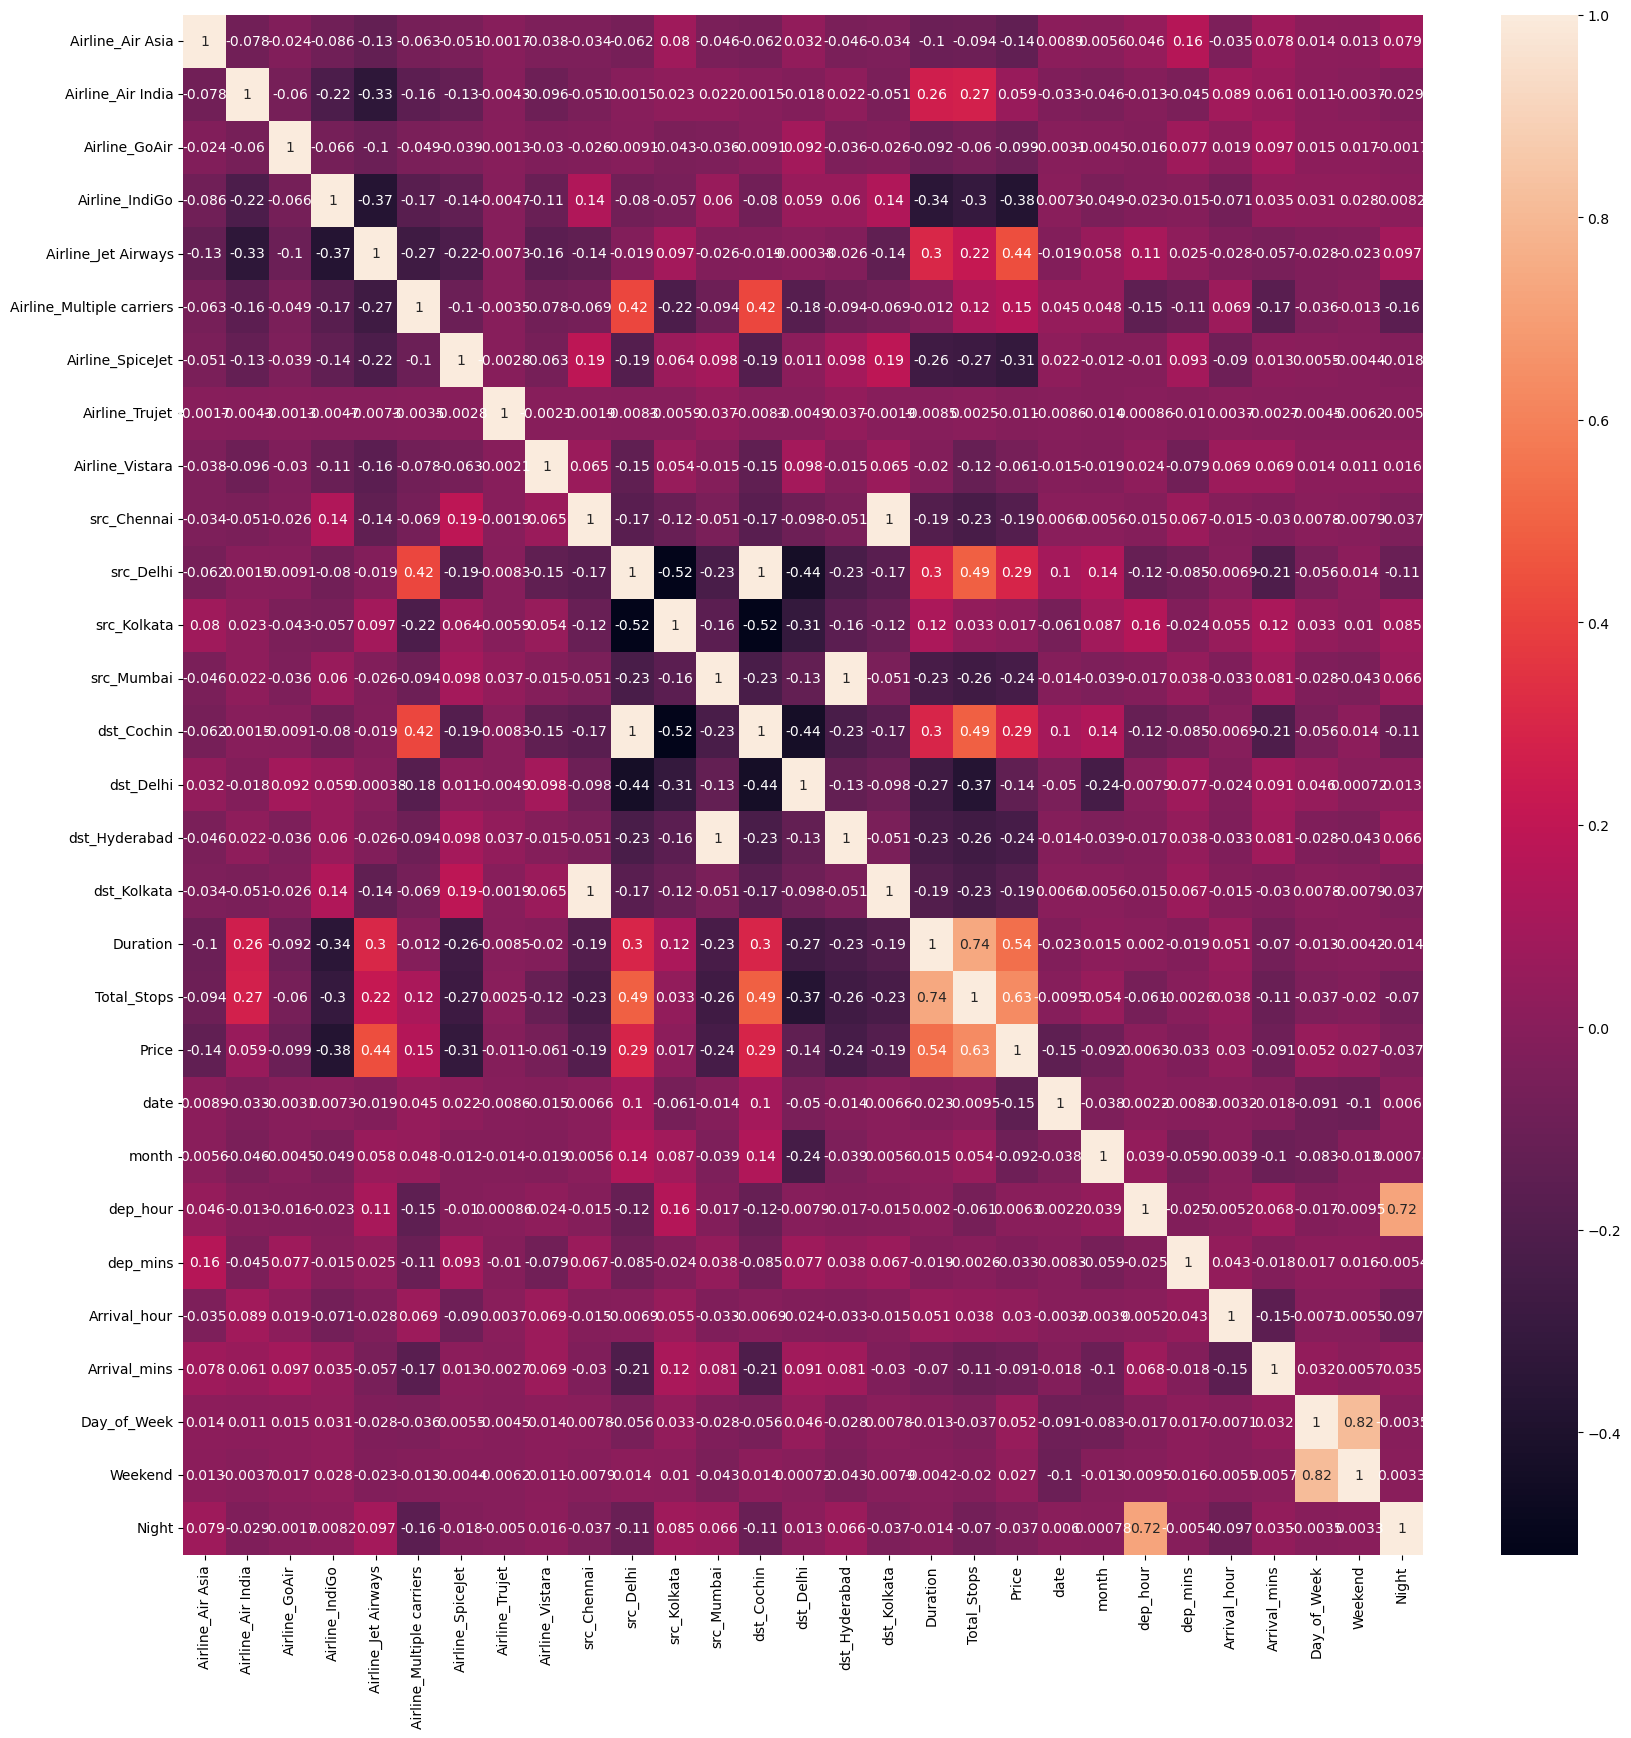

In [55]:
#Finding correlation between Dependent and independent features
plt.figure(figsize=(20,20))
corr= final_df.corr()
sns.heatmap(corr, annot= True)
plt.show()

## 10. Feature Selection

In [56]:
select = ExtraTreesRegressor()
select.fit(X,y)

ExtraTreesRegressor()

In [57]:
print(select.feature_importances_)

[0.00271364 0.01480271 0.00209758 0.01528863 0.15022215 0.026225
 0.00567318 0.00564647 0.00087195 0.01364864 0.00563186 0.00853569
 0.01222131 0.01550705 0.01066375 0.00077697 0.11491439 0.28680179
 0.10660137 0.05987521 0.02449911 0.02795529 0.02531303 0.02340099
 0.02222097 0.01135269 0.00653858]


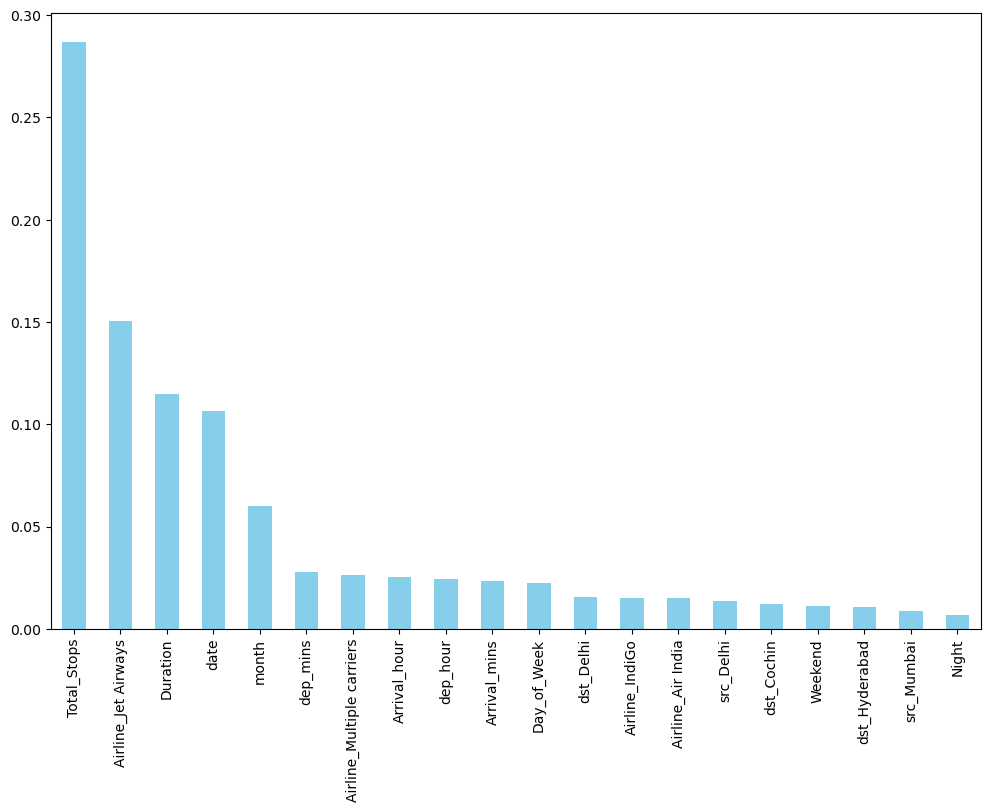

In [58]:
plt.figure(figsize =(12,8))
feat_importances = pd.Series(select.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar',color = 'skyblue')
plt.show()

In [59]:
best_feature = SelectKBest(score_func=chi2,k=10)
best_feature.fit(X,y)

SelectKBest(score_func=<function chi2 at 0x00000155EC3562A0>)

In [60]:
best_feature.scores_

array([9.89386512e+03, 8.61039129e+03, 9.37104669e+03, 7.89027620e+03,
       6.70806868e+03, 9.26899121e+03, 8.66645523e+03, 1.00647016e+04,
       1.00779468e+04, 6.00266713e+03, 7.63374408e+03, 9.78053943e+03,
       6.00266713e+03, 8.27906159e+03, 9.78053943e+03, 1.00779468e+04,
       3.34279121e+06, 5.77823329e+03, 2.24852997e+04, 2.42395139e+03,
       1.10233316e+04, 6.77951156e+04, 1.89146290e+04, 5.03908705e+04,
       5.15392918e+03, 2.54150735e+03, 2.70874827e+03])

In [61]:
dfscores=pd.DataFrame(best_feature.scores_,columns=['Score'])
dfcolumns=pd.DataFrame(X.columns)
final_feature = pd.concat([dfscores,dfcolumns],axis=1)
final_feature.columns=['Scores','Feature']
final_feature

,Scores,Feature
0,9.893865e+03,Airline_Air Asia
1,8.610391e+03,Airline_Air India
2,9.371047e+03,Airline_GoAir
3,7.890276e+03,Airline_IndiGo
4,6.708069e+03,Airline_Jet Airways
5,9.268991e+03,Airline_Multiple carriers
6,8.666455e+03,Airline_SpiceJet
7,1.006470e+04,Airline_Vistara
8,1.007795e+04,src_Chennai
9,6.002667e+03,src_Delhi


In [62]:
final_feature.nlargest(10,'Scores')

,Scores,Feature
16,3.342791e+06,Duration
21,6.779512e+04,dep_mins
23,5.039087e+04,Arrival_mins
18,2.248530e+04,date
22,1.891463e+04,Arrival_hour
20,1.102333e+04,dep_hour
8,1.007795e+04,src_Chennai
15,1.007795e+04,dst_Kolkata
7,1.006470e+04,Airline_Vistara
0,9.893865e+03,Airline_Air Asia


## Test data Processing

In [63]:
data = pd.read_excel(r"C:\Users\49179\Desktop\EDA\Flight fare Prediction\Test_set.xlsx")

In [64]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [65]:
data['Airline'].unique()

array(['Jet Airways', 'IndiGo', 'Multiple carriers', 'Air Asia',
       'Air India', 'Vistara', 'SpiceJet', 'Vistara Premium economy',
       'GoAir', 'Multiple carriers Premium economy',
       'Jet Airways Business'], dtype=object)

In [66]:
data.shape

(2671, 10)

In [67]:
#Finding Missing values
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [68]:
# Feature generation
# Separating date and month from 
data['date'] = pd.to_datetime(data['Date_of_Journey'],format="%d/%m/%Y").dt.day

data['month'] = pd.to_datetime(data['Date_of_Journey'],format="%d/%m/%Y").dt.month

# separating hour and minute from the departure time
data['dep_hour'] = pd.to_datetime(data.Dep_Time).dt.hour

data['dep_mins'] = pd.to_datetime(data.Dep_Time).dt.minute
# separating hour and minute from the departure time
data['Arrival_hour'] = pd.to_datetime(data.Arrival_Time).dt.hour

data['Arrival_mins'] = pd.to_datetime(data.Arrival_Time).dt.minute


# Converting Duration into minuts
x = list(data['Duration'])
for i in range(len(x)):
    if len(x[i].split()) != 2:
        if "h" in x[i]:
            x[i] = x[i].strip() + " " + '0m'
        else:
            x[i] = "0h" + " " + x[i]

x_hour_in_mins=[]
x_min=[]
for i in range(len(x)):
    #Extracting hour and converting it into minutes
    x_hour_in_mins.append(int(x[i].split(sep = "h")[0])*60)
    # Extracting minutes from duration
    x_min.append(int(x[i].split(sep = "m")[0].split()[-1]))
    
# making it one feature
data['Duration'] = pd.DataFrame(x_hour_in_mins) + pd.DataFrame(x_min)


# Creating a feature named Day_of_Week

data['Day_of_Week'] = pd.to_datetime(data['Date_of_Journey'],format='%d/%m/%Y').dt.dayofweek

# Now, we will create weekend column
data['Weekend'] = (pd.to_datetime(data['Date_of_Journey'],format ='%d/%m/%Y').dt.dayofweek >= 5).astype(int)

# Generating a feature based on day time
data['Night'] = (pd.to_datetime(data['Dep_Time'], format = '%H:%M').dt.hour >= 19).astype(int)

In [69]:
# Data Inconsistency
stops= {'non-stop': 0,'1 stop': 1, '2 stops' :2, '3 stops' :3, '4 stops': 4}

# let's perform ordinal encoding

data['Total_Stops'] = data['Total_Stops'].map(stops)

# Replacing name of airlines
data['Airline'] =  data['Airline'].replace('Jet Airways Business', 'Jet Airways')
data['Airline'] =  data['Airline'].replace('Vistara Premium economy', 'Vistara')
data['Airline'] =  data['Airline'].replace('Multiple carriers Premium economy', 'Multiple carriers')

data.Destination = data.Destination.replace('New Delhi','Delhi')

In [70]:
# Let's make dummy variables for categorical features
Airline = pd.get_dummies(data['Airline'], prefix ="Airline",prefix_sep="_")
src = pd.get_dummies(data['Source'], prefix ="src",prefix_sep="_" ,drop_first=True)
dst = pd.get_dummies(data['Destination'], prefix ="dst",prefix_sep="_" ,drop_first=True)
X_test = pd.concat([Airline,src,dst,data],axis=1)


In [71]:
# Dropping Features
X_test.drop(['Date_of_Journey','Dep_Time','Arrival_Time', 'Route', 'Additional_Info','Airline',"Source", 'Destination'],axis=1, inplace=True)

In [72]:
X_test.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Vistara,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata,Duration,Total_Stops,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,655,1,6,6,17,30,4,25,3,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,240,1,12,5,6,20,10,20,6,1,0
2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1425,1,21,5,19,15,19,0,1,0,1
3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,780,1,21,5,8,0,21,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,170,0,24,6,23,55,2,45,0,0,1


In [73]:
X.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Vistara,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai,dst_Cochin,dst_Delhi,dst_Hyderabad,dst_Kolkata,Duration,Total_Stops,date,month,dep_hour,dep_mins,Arrival_hour,Arrival_mins,Day_of_Week,Weekend,Night
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,170,0,24,3,22,20,1,10,6,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,445,2,1,5,5,50,13,15,2,0,0
2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1140,2,9,6,9,25,4,25,6,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,325,1,12,5,18,5,23,30,6,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,285,1,1,3,16,50,21,35,4,0,0


In [74]:
X_test.shape

(2671, 27)

In [75]:
Y_test = pd.read_excel(r"C:\Users\49179\Desktop\EDA\Flight fare Prediction\Sample_submission.xlsx")

In [76]:
Y_test.shape

(2671, 1)

In [77]:
Y_test.isnull().sum()

Price    0
dtype: int64

## 11. Model Selection

In [78]:
def prediction(base_model):
    print(f'Model: {base_model}')
    model = base_model.fit(X,y)
    Score = model.score(X,y)
    print(f"Model score: {float(format(Score,'.3f'))}")
    prediction = model.predict(X_test)
    print(f'Predictions: {prediction}')
    print(f"r2 score is: {float(format(r2_score(Y_test,prediction),'.3f'))}")
          
    print(f"MAE: {float(format(mean_absolute_error(Y_test,prediction),'.3f'))}")
    print(f"MSE: {float(format(mean_squared_error(Y_test,prediction),'.3f'))}")

In [79]:
prediction(LogisticRegression())

Model: LogisticRegression()
Model score: 0.047
Predictions: [10262. 10844. 10262. ... 11087. 10844. 11087.]
r2 score is: -4.965
MAE: 10869.949
MSE: 149389948.694


C:\Users\49179\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
prediction(KNeighborsRegressor())

Model: KNeighborsRegressor()
Model score: 0.745
Predictions: [11574.6  4226.  13433.2 ... 13880.4  8584.6  7716.6]
r2 score is: -5.527
MAE: 11258.664
MSE: 163459759.344


In [81]:
prediction(DecisionTreeRegressor())

Model: DecisionTreeRegressor()
Model score: 0.959
Predictions: [10262.   4226.  14488.5 ... 13843.  15809.   7155. ]
r2 score is: -5.659
MAE: 11328.371
MSE: 166781894.933


In [82]:
prediction(SVR())

Model: SVR()
Model score: 0.218
Predictions: [ 8695.27187785  7299.76805047 10065.89627188 ...  7752.31719516
  9531.27629144  9378.84125605]
r2 score is: -5.59
MAE: 11794.106
MSE: 165033921.681


In [83]:
prediction(RandomForestRegressor(n_estimators = 100, random_state = 0))

Model: RandomForestRegressor(random_state=0)
Model score: 0.947
Predictions: [10651.25066667  4282.71       14621.83521429 ... 14459.73983333
 14700.87        7736.44      ]
r2 score is: -5.552
MAE: 11232.756
MSE: 164085670.767


In [84]:
prediction(XGBRegressor())

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Model score: 0.928
Predictions: [11522.143  4900.515 14260.086 ... 15646.658 12826.095  8173.738]
r2 score is: -5.566
MAE: 11259.867
MSE: 164453027.972


In [85]:
## 12.Hypertunning the model
RFR = RandomForestRegressor()

In [86]:
parameters = {
    'n_estimators' : [100, 120, 160, 180, 200,220],
    'max_features':['sqrt'],
    'max_depth':[5,10,15,20],
    }

RF_randomsearch = RandomizedSearchCV(estimator = RFR, param_distributions=parameters, cv=3, verbose=2,n_jobs=-1,)
RF_randomsearch.fit(X,y)
RF_randomsearch.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 15}

In [87]:
Y_pred = RF_randomsearch.predict(X_test)
Score = RF_randomsearch.score(X,y)
print(f"Model score: {float(format(Score,'.3f'))}")
print(f'Predictions: {Y_pred}')
print(f"r2 score is: {float(format(r2_score(Y_test,Y_pred),'.3f'))}")

print(f"MAE: {float(format(mean_absolute_error(Y_test,Y_pred),'.3f'))}")
print(f"MSE: {float(format(mean_squared_error(Y_test,Y_pred),'.3f'))}")

Model score: 0.918
Predictions: [11848.32854573  4511.77394827 14006.1557344  ... 13761.51859619
 13197.55332011  9194.18923987]
r2 score is: -5.5
MAE: 11223.17
MSE: 162799829.095
